# 16 Plot sea-ice changes #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import pandas as pd
import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts, colour_dict
from cdrmip_extremes import utils, load_data

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

In [3]:
data = load_data.load_siconc()

In [4]:
concat = {}
for model in models:
    ds_up = data[model]['1pctCO2']
    ds_down = data[model]['1pctCO2-cdr']
    concat[model] = utils.concat_branches(
        ds_up,
        ds_down
    )

In [5]:
areacello = load_data.load_areacello()

### Ensure coordinates are consistent ###

In [6]:
for model, ds in concat.items():
    print(model)
    print(ds.dims)
    print(list(ds.coords))

ACCESS-ESM1-5
('time', 'j', 'i')
['j', 'i', 'latitude', 'longitude', 'type', 'time']
CanESM5
('time', 'j', 'i')
['j', 'i', 'latitude', 'longitude', 'type', 'time']
CESM2
('time', 'nj', 'ni')
['lat', 'lon', 'ni', 'nj', 'time']
CNRM-ESM2-1
('time', 'y', 'x')
['lat', 'lon', 'type', 'time']
GFDL-ESM4
('time', 'y', 'x')
['lat', 'lon', 'x', 'y', 'time']
MIROC-ES2L
('time', 'y', 'x')
['y', 'x', 'latitude', 'longitude', 'type', 'time']
NorESM2-LM
('time', 'j', 'i')
['j', 'i', 'latitude', 'longitude', 'type', 'time']
UKESM1-0-LL
('time', 'j', 'i')
['j', 'i', 'latitude', 'longitude', 'type', 'time']


In [7]:
for model, ds in concat.items():
    # Check and rename 'lat' to 'latitude'
    if 'lat' in ds.coords:
        ds = ds.rename({'lat': 'latitude'})
    
    # Check and rename 'lon' to 'longitude'
    if 'lon' in ds.coords:
        ds = ds.rename({'lon': 'longitude'})
    
    concat[model] = ds

In [8]:
for model, si in concat.items():
    if 'ni' in list(si.dims):
        print(f"Changing {model} dim 'ni'")
        concat[model] = si.rename({'ni':'i','nj':'j'})
    elif 'y' in list(si.dims):
        print(f"Changing {model} dim 'y'")
        concat[model] = si.rename({'x':'i','y':'j'})

Changing CESM2 dim 'ni'
Changing CNRM-ESM2-1 dim 'y'
Changing GFDL-ESM4 dim 'y'
Changing MIROC-ES2L dim 'y'


In [9]:
for model, si in areacello.items():
    if 'ni' in list(si.dims):
        print(f"Changing {model} dim 'ni'")
        areacello[model] = si.rename({'ni':'i','nj':'j'})
    if 'y' in list(si.dims):
        print(f"Changing {model} dim 'y'")
        areacello[model] = si.rename({'x':'i','y':'j'})
    if 'nlat' in list(si.dims):
        print(f"Changing {model} dim 'nlat'")
        areacello[model] = si.rename({'nlat':'j','nlon':'i'})

Changing CESM2 dim 'nlat'
Changing CNRM-ESM2-1 dim 'y'
Changing GFDL-ESM4 dim 'y'
Changing MIROC-ES2L dim 'y'


## Calculate Regional Averages ##

In [10]:
si_weighted = {model:{} for model in models}
for model, siconc in concat.items():
    print(f"processing {model}")
    arctic = siconc.where(siconc['latitude']>=60)
    antarctic = siconc.where(siconc['latitude']<=-60)
    for pole, pole_si in [('Arctic',arctic),('Antarctic',antarctic)]:
        weighted = pole_si.weighted(
            weights=areacello[model].fillna(0)
        ).mean(dim=('i','j'))
        si_weighted[model][pole] = weighted.compute()

processing ACCESS-ESM1-5
processing CanESM5
processing CESM2
processing CNRM-ESM2-1
processing GFDL-ESM4
processing MIROC-ES2L
processing NorESM2-LM
processing UKESM1-0-LL


In [11]:
gwl_years = load_data.load_gwl_years()

In [12]:
def plot_siconc(siconc,fig,ax,region,gwl_years):

    for model in models:
        da = siconc[model][region].groupby('time.year').mean(dim='time')
        da_rolling = da.rolling(year=21,center=True,min_periods=1).mean()
        da.plot(ax=ax,color=colour_dict[model],linewidth=2,alpha=0.3)
        da_rolling.plot(ax=ax,label=model,color=colour_dict[model],linewidth=2)

        # plot 1.5 crossing year
        gwl_up = gwl_years[model].sel(branch='ramp_up',gwl=1.5)
        gwl_down = gwl_years[model].sel(branch='ramp_down',gwl=1.5)

        ax.scatter(
            gwl_up,
            da_rolling.sel(year=gwl_up),
           marker='^',
          color=colour_dict[model],
          s=400,
          # label='1.5$^o$C ramp-up'
        )
        ax.scatter(gwl_down,
           da_rolling.sel(year=gwl_down),
           marker='v',
          color=colour_dict[model],
          s=400,
          # label='1.5$^o$C ramp-down'
                  )

    ax.set_ylabel('Sea Ice Concentration (%)',fontsize=12)

    ax.set_xlabel('Year',fontsize=12)
    ax.set_xlim([0,350])
    ax.axvline(x = 140, color = 'gray',linewidth=1.0,linestyle='--',alpha=0.7)
    ax.axvline(x = 280, color = 'gray',linewidth=1.0,linestyle='--',alpha=0.7)
     

    ax.set_title(f"{region} Sea Ice Concentration",fontsize=18)


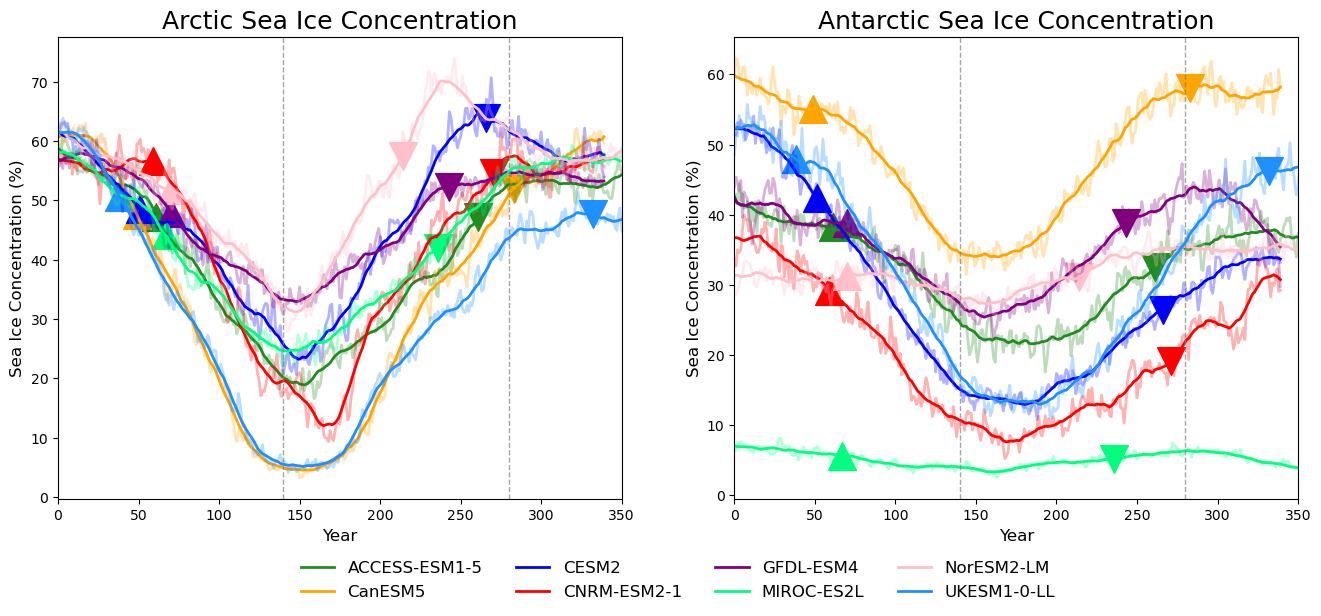

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

plot_siconc(si_weighted,fig,ax1,'Arctic',gwl_years)
plot_siconc(si_weighted,fig,ax2,'Antarctic',gwl_years)
ax1.legend(loc='lower center',bbox_to_anchor = (1.1,-0.25),ncol=4,frameon=False,fontsize=12)